In [1]:
## Load packages
import sys
import torch
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output

from tumorpde.models.deform import TumorDeformFD
from tumorpde.volume_domain import VolumeDomain
from tumorpde.models._base import default_init_density, default_init_density_deriv

# Ensure the proper device is used
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.set_default_device(device)

In [2]:
import importlib
importlib.reload(sys.modules['tumorpde._typing'])
# importlib.reload(sys.modules['tumorpde.models.volume_domain'])
importlib.reload(sys.modules['tumorpde.models._base'])
importlib.reload(sys.modules['tumorpde.models.comp_utils'])
importlib.reload(sys.modules['tumorpde.models.deform'])
importlib.reload(sys.modules['tumorpde.volume_domain'])

<module 'tumorpde.volume_domain' from '/home/muye/Projects/2024_01_BrainTumorDiffusion/TumorPDE/tumorpde/volume_domain.py'>

## Data Generation

In [12]:
# define the grid of the spatial domain 
dx = 0.1
x_range = (0., 10.)
nx = int((x_range[1] - x_range[0]) / dx + 1)
x_grid = np.linspace(x_range[0], x_range[1], nx)

# define a domain mask
domain_interval = np.logical_and(x_grid >= 1., x_grid <= 9.)
domain_mask = np.zeros_like(x_grid) + 1. * domain_interval
fake_gm = np.zeros_like(x_grid) + \
    (0.2 + np.sin(np.pi * (x_grid - 2.))) * np.logical_and(x_grid >= 2., x_grid <= 3.) + \
    (0.2 + np.sin(np.pi * (x_grid - 7.))) * np.logical_and(x_grid >= 7., x_grid <= 8.)
# + \
#     (0.1 + np.sin(2 * np.pi * (x_grid - 3.5))) * np.logical_and(x_grid >= 3.5, x_grid <= 4.) + \
#     (0.1 + np.sin(2 * np.pi * (x_grid - 6.))) * np.logical_and(x_grid >= 6., x_grid <= 6.5)
fake_wm = np.zeros_like(x_grid) + \
    (0.1 + np.sin(np.pi * (x_grid - 3.) / 1.5)) * np.logical_and(x_grid >= 3., x_grid <= 4.5) + \
    (0.1 + np.sin(np.pi * (x_grid - 5.5) / 1.5)) * np.logical_and(x_grid >= 5.5, x_grid <= 7.)
fake_csf = np.zeros_like(x_grid) + \
    (0.05 + 0.1 * np.sin(np.pi * (x_grid - 4.) / 2)) * np.logical_and(x_grid >= 4., x_grid <= 6.) + \
    (0.05 + 0.1 * np.sin(np.pi * (x_grid - 1.))) * np.logical_and(x_grid >= 1., x_grid <= 2.) + \
    (0.05 + 0.1 * np.sin(np.pi * (x_grid - 8.))) * np.logical_and(x_grid >= 8., x_grid <= 9.)

geom = VolumeDomain(domain_mask, voxel_widths=[dx])
t0, t1 = (0., 1.)

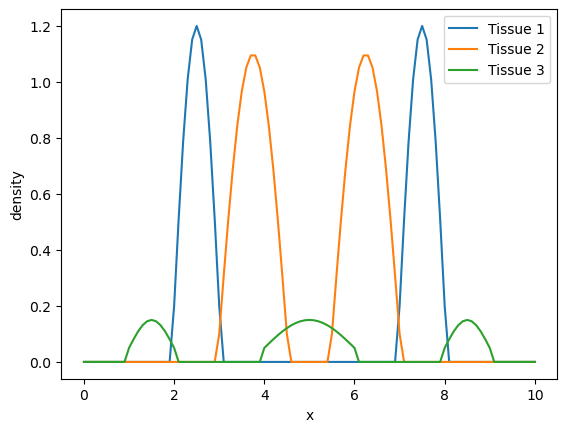

In [46]:
plt.figure()
plt.plot(x_grid, fake_gm, label='Tissue 1')
plt.plot(x_grid, fake_wm, label='Tissue 2')
plt.plot(x_grid, fake_csf, label='Tissue 3')
# plt.plot(x_grid, fake_gm + fake_wm + fake_csf, label='sum')
plt.legend()
plt.xlabel('x')
plt.ylabel('density')
plt.show()

In [47]:
matters = torch.cat([
    torch.tensor(fake_gm, device=device).unsqueeze(0),
    torch.tensor(fake_wm, device=device).unsqueeze(0),
    torch.tensor(fake_csf, device=device).unsqueeze(0)
], dim=0)

In [48]:
# randomly set up the parameters
D = 1.
alpha = 20.
cx = [6.]
M = 1.
kappa = 1.
D_ratio = 0.3
# kappa_ratios = [0.01, 0.1]
kappa_ratios = [0.1, 0.5]
init_peak_height = 0.01
init_peak_width = 0.1
init_density_params = {
  'w': init_peak_width,
  'h': init_peak_height,
  'rmax': 3.*dx
}

# create the PDE model
pde = TumorDeformFD(geom, matters,
                    D, alpha, M, kappa,
                    D_ratio, kappa_ratios,
                    init_learnable_params=cx,
                    init_other_params=init_density_params)

In [49]:
dt = 0.001
state, t = pde.solve(None, dt, t1 = 0.001)

In [59]:
dt = 0.001
state, t = pde.solve(state, dt, t1 = 0.1)

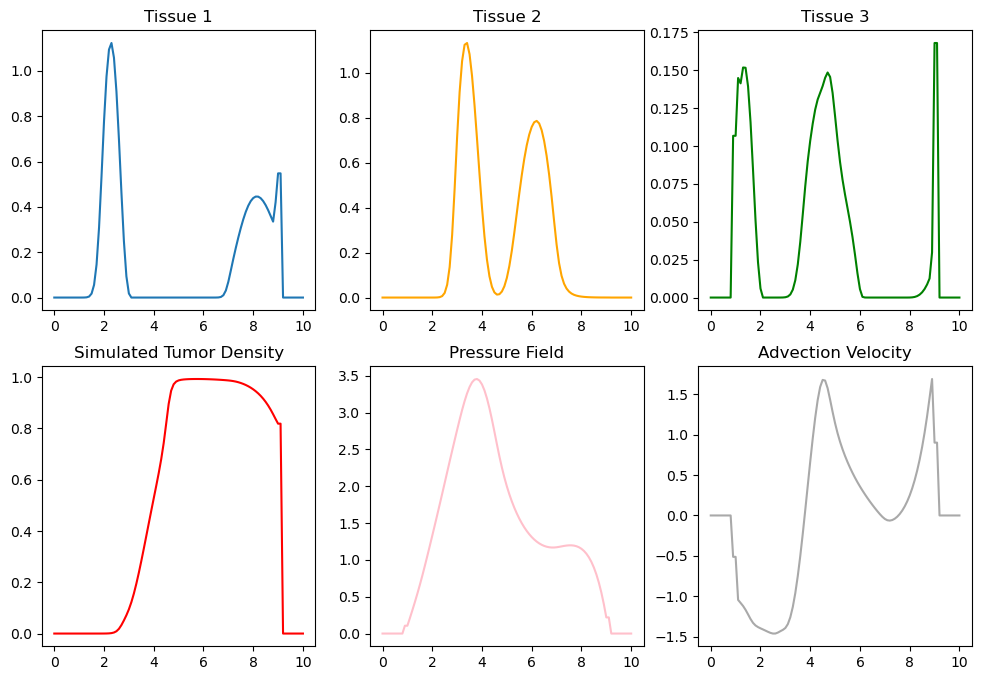

In [60]:
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(12, 8))
ax[0][0].plot(x_grid, state.brain_density[0].cpu().numpy(),
              label='grey matter')
ax[0][0].set_title('Tissue 1')
ax[0][1].plot(x_grid, state.brain_density[1].cpu().numpy(),
              label='white matter', color="orange")
ax[0][1].set_title('Tissue 2')
ax[0][2].plot(x_grid, state.brain_density[2].cpu().numpy(), label='csf', color="green")
ax[0][2].set_title('Tissue 3')
ax[1][0].plot(x_grid, state.tumor_density.cpu().numpy(), label='tumor density', color="red")
ax[1][0].set_title('Simulated Tumor Density')
ax[1][1].plot(x_grid, state.pressure_field.cpu().numpy(),
              label='tumor density', color="pink")
ax[1][1].set_title('Pressure Field')
ax[1][2].plot(x_grid, state.deform_velocity[0].cpu().numpy(),
              label='grey matter', color="darkgrey")
ax[1][2].set_title('Advection Velocity')
plt.show()